In [589]:
import json
import math
import matplotlib.pyplot as plt
import numpy as np
import os

In [590]:
ORIGINAL_FPS = 30
MANUAL_FPSS = ['1', '2', '3', '5', '6', '10', '15']
USE_MANUAL_FPSS = True
THRESHOLD = 0.75

In [591]:
accuracy_result_dict_paths = [
	# '../assets/result/accuracy_movement/Video1_Accuracy_Result.json',
    # '../assets/result/accuracy_movement/Video2_Accuracy_Result.json',
    '../assets/result/accuracy_movement/Video3_Accuracy_Result.json',
    # '../assets/result/accuracy_movement/Video4_Accuracy_Result.json',
]

In [592]:
movement_result_dict_paths = [
	# '../assets/result/accuracy_movement/Video1_Movement_Result.json',
    # '../assets/result/accuracy_movement/Video2_Movement_Result.json',
    '../assets/result/accuracy_movement/Video3_Movement_Result.json',
    # '../assets/result/accuracy_movement/Video4_Movement_Result.json',
]

In [593]:
def round_floats_to_sigfigs(input_list, sigfigs):
	return [round(number, sigfigs) for number in input_list]

In [594]:
def load_json(filepath):
	with open(filepath, 'r') as file:
		data = json.load(file)
		
	return data

In [595]:
def extract_fpss(metric_list, data_type='metric'):
	return list(metric_list[list(metric_list.keys())[0]][0][data_type].keys())

In [596]:
def extract_metric_list(metric_list, fpss, feature='F1', data_type='metric'):
	result_column = {}
		
	for fps in fpss:
		if data_type == 'metric':
			result_column[fps] = [clip_metric[data_type][fps][feature] for clip_metric in metric_list]
		elif data_type == 'movement':
			result_column[fps] = [clip_metric[data_type][fps] for clip_metric in metric_list]
		
	return result_column

In [597]:
def cumulative_sum_list(input_list):
	result = []
	total = 0
	for item in input_list:
		total += item
		result.append(total)
	return result

def extract_metric_time(metric_list):
	frame_number_list = [clip_metric['frame_count'] for clip_metric in metric_list]
	time_list = cumulative_sum_list(frame_number_list)
	time_list = list(np.array(time_list) - time_list[0])
	scaled_time_list = list(np.array(time_list) / ORIGINAL_FPS)

	return round_floats_to_sigfigs(scaled_time_list, 0)

In [598]:
colors = [
	'#e6194B',
	'#f58231',
	'#9A6324',
	'#911eb4',
	'#3cb44b',
	'#f032e6',
	'#4363d8',
  '#f7cc1d',
]

In [599]:
def find_max_index(string_list):
	# Convert each element to integer
	int_list = [int(element) for element in string_list]
		
	# Find index of maximum integer value
	max_index, max_value = max(enumerate(int_list), key=lambda x: x[1])
		
	return max_value

In [600]:
def extract_cheapest_fps(accuracy_dict, fpss, threshold=0.75, use_MANUAL_FPSS=False):
	if use_MANUAL_FPSS:
		fpss = MANUAL_FPSS
	else:
		fpss = fpss
				
	max_fps = find_max_index(fpss)
	
	cheapest_fpss = []
	for i in range(len(accuracy_dict[fpss[0]])):
		curr_fps = max_fps
		for fps in fpss:
			if accuracy_dict[fps][i] >= threshold and int(fps) < int(curr_fps):
				curr_fps = fps
		
		cheapest_fpss.append(int(curr_fps))
	
	return cheapest_fpss

In [601]:
def duplicate_elements_accuracy(input_list):
	result = []
	for item in input_list:
		result.append(item)
		result.append(item)
	return result

In [602]:
def duplicate_elements_time(input_list):
	result = [0]
	for item in input_list:
		if item == input_list[-1]:
			result.append(item)
			break
		result.append(item)
		result.append(item)
	return result

def cumulative_sum_list(input_list):
	result = []
	total = 0
	for item in input_list:
		total += item
		result.append(total)
	return result

def extract_metric_time_horizontal(metric_list):
	frame_number_list = [clip_metric['frame_count'] for clip_metric in metric_list]
	time_list = cumulative_sum_list(frame_number_list)
	time_list = duplicate_elements_time(time_list)
	scaled_time_list = list(np.array(time_list) / ORIGINAL_FPS)

	return round_floats_to_sigfigs(scaled_time_list, 0)

In [603]:
def plot_one_line(xs, ys, x_label, y_label, label, plot_size=(5, 4), line_color=colors[0], label_size=16, font_size=24, legend_size=16):
	fig, ax1 = plt.subplots(figsize=plot_size)
	
	ax1.plot(xs, ys, color=line_color, label=label, marker='o')

	ax1.set_xlabel(x_label, fontsize=font_size)
	ax1.set_ylabel(y_label, fontsize=font_size)
	# ax1.set_title(title, fontsize=font_size)
	plt.xticks(fontsize=label_size)
	plt.yticks(fontsize=label_size)
	# plt.legend(fontsize=legend_size)
	plt.grid(True)

	plt.show()

In [604]:
accuracy_at_fps = []

for result_dict_path in accuracy_result_dict_paths:
	result_dict = load_json(result_dict_path)
	fpss = extract_fpss(result_dict)

	for class_idx in list(result_dict.keys()):
		accuracy = extract_metric_list(result_dict[class_idx], fpss)
		time = extract_metric_time(result_dict[class_idx])

		for fps in MANUAL_FPSS:
			accuracy_at_fps.append(np.average(accuracy[fps]))


In [605]:
power_at_fps = []
power_at_all_fps = load_json('../assets/result/energy/Dict-Per-Real-Second-Throughput-960.json')

for fps in MANUAL_FPSS:
	power_at_fps.append(power_at_all_fps[str(fps)])

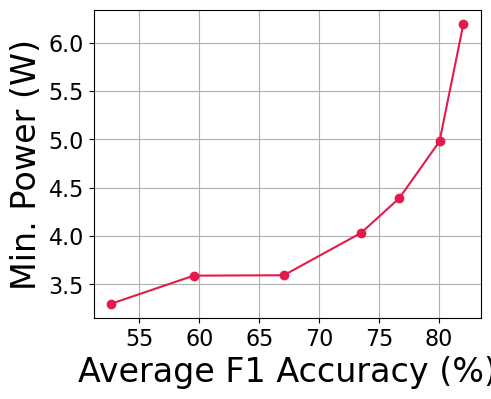

In [606]:
# Average Accuracy vs Power
processed_accuracy_at_fps = list(np.array(accuracy_at_fps)*100)
plot_one_line(processed_accuracy_at_fps, power_at_fps, 'Average F1 Accuracy (%)', 'Min. Power (W)', 'Average Accuracy vs Power')

In [607]:
def plot_multiple_line(xss, yss, x_label, y_label, plot_size=(5, 4), line_color=colors[0], alpha=0.5, label_size=16, font_size=24, legend_size=16):
	fig, ax1 = plt.subplots(figsize=plot_size)
	
	for i in range(len(xss)):
		ax1.plot(xss[i], yss[i], color=line_color, alpha=alpha, marker='o')

	ax1.set_xlabel(x_label, fontsize=font_size)
	ax1.set_ylabel(y_label, fontsize=font_size)
	# ax1.set_title(title, fontsize=font_size)
	plt.xticks(fontsize=label_size)
	plt.yticks(fontsize=label_size)
	# plt.legend(fontsize=legend_size)
	plt.grid(True)

	plt.show()

In [608]:
accuracy_at_fps_list = []
num_clips = -1

for result_dict_path in accuracy_result_dict_paths:
	result_dict = load_json(result_dict_path)
	fpss = extract_fpss(result_dict)

	for class_idx in list(result_dict.keys()):
		accuracy = extract_metric_list(result_dict[class_idx], fpss)
		num_clips = len(accuracy[list(accuracy.keys())[0]])

		for i in range(num_clips):
			accuracy_at_fps_single = []
			for fps in MANUAL_FPSS:
				accuracy_at_fps_single.append(accuracy[fps][i])
			accuracy_at_fps_list.append(accuracy_at_fps_single)

In [609]:
power_at_fps = []
power_at_all_fps = load_json('../assets/result/energy/Dict-Per-Real-Second-Throughput-960.json')
for fps in MANUAL_FPSS:
	power_at_fps.append(power_at_all_fps[str(fps)])

power_at_fps_list = []
for i in range(num_clips):
	power_at_fps_list.append(power_at_fps)

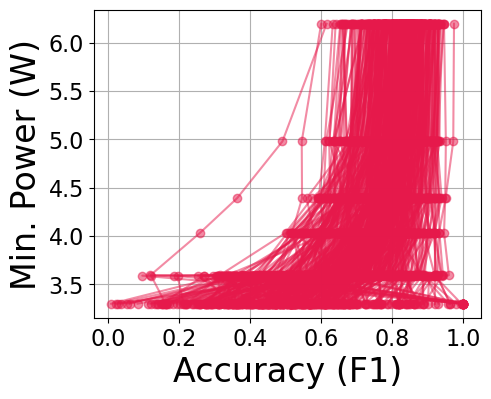

In [610]:
# Individual Accuracy vs Power
plot_multiple_line(accuracy_at_fps_list, power_at_fps_list, 'Accuracy (F1)', 'Min. Power (W)')

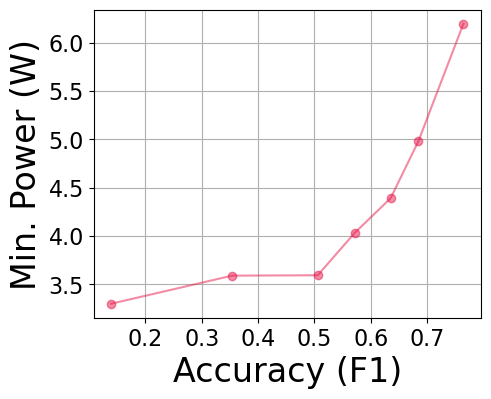

In [611]:
# Only One Clip Accuracy vs Power
plot_multiple_line(accuracy_at_fps_list[5:6], power_at_fps_list[5:6], 'Accuracy (F1)', 'Min. Power (W)')

In [612]:
def average_of_columns(matrix):
    # Calculate the number of columns
    num_columns = len(matrix[0])
    
    # Initialize a list to store the averages
    averages = []
    
    # Iterate over each column
    for i in range(num_columns):
        column_values = [row[i] for row in matrix]  # Extract the ith column
        column_average = sum(column_values) / len(column_values)  # Calculate the average
        averages.append(column_average)  # Append the average to the list
    
    return averages

def combine_times(matrix, interval):
    result = []
    new_len = math.floor(len(matrix) / interval)

    for i in range(new_len):
        result.append(average_of_columns(matrix[i:i+interval]))
    
    return result

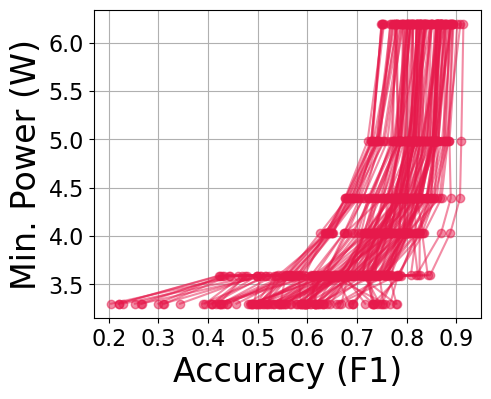

In [613]:
# Combined Accuracy vs Power
interval = 4
plot_multiple_line(combine_times(accuracy_at_fps_list, interval), combine_times(power_at_fps_list, interval), 'Accuracy (F1)', 'Min. Power (W)')